In [1]:
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [2]:
def rgb2gray(img):
    gray = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]
    return gray


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
(32, 32, 1)


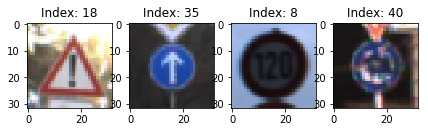

In [3]:
# Load pickled data
# TODO: Fill this in based on where you saved the training and testing data
training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.copy(y_train)
n_classes = len(set(n_classes))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline

t_i = []
img = []
for i in range(4):
    t_i.append(random.randint(0, len(X_train)))
    img.append(X_train[t_i[-1]].squeeze())

fig = plt.figure(figsize=(7,7))
for i in range(4):
    sf = fig.add_subplot(1, 4, i+1)
    plt.imshow(img[i], cmap="gray")
    sf.set_title("Index: "+str(y_train[t_i[i]]))

### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale

X_train = [rgb2gray(img).reshape((32,32,1)) for img in X_train]
X_valid = [rgb2gray(img).reshape((32,32,1)) for img in X_valid]
X_test = [rgb2gray(img).reshape((32,32,1)) for img in X_test]
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

#plt.imshow(X_train[0])
print(X_train[0].shape)

In [4]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def model(x):
    mu = 0
    sigma = 0.1
    keep_prob = 0.9
    weights = {
        "cnv1": tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma)),
        "cnv2": tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = mu, stddev = sigma)),
        "cnv3": tf.Variable(tf.truncated_normal(shape=(1568, 512), mean = mu, stddev = sigma)),
        "cnv4": tf.Variable(tf.truncated_normal(shape=(512, 172), mean = mu, stddev = sigma)),
        "cnv5": tf.Variable(tf.truncated_normal(shape=(172, n_classes), mean = mu, stddev = sigma))
    }
    biases = {
        'bcv1': tf.Variable(tf.zeros([32])),
        'bcv2': tf.Variable(tf.zeros([32])),
        'bcv3': tf.Variable(tf.zeros([512])),
        'bcv4': tf.Variable(tf.zeros([172])),
        'bcv5': tf.Variable(tf.zeros([n_classes]))
    }
    # Layer 1: Convolutional. Input=32x32x1, Output = 32x32x32
    layer = tf.nn.conv2d(x, weights['cnv1'], strides=[1,1,1,1], padding="SAME") + biases['bcv1']
    layer = tf.nn.relu(layer)
    #Pooling, Input = 32x32x32, Output = 16x16x32
    layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
    # Layer 2: Convolutional. Input=16x16x32, Output = 14x14x32
    layer = tf.nn.conv2d(layer, weights['cnv2'], strides=[1,1,1,1], padding="VALID") + biases['bcv2']
    layer = tf.nn.relu(layer)
    #Pooling, Input = 14x14x32, Output = 7x7x32
    layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
    #flatten the image, output = 1568
    layer = flatten(layer)
    layer = tf.nn.dropout(layer, keep_prob) #keep_prob = 0.9
    
    #Layer 3: Fully connected Input = 1568, Output = 512
    layer = tf.add(tf.matmul(layer, weights['cnv3']), biases['bcv3'])
    layer = tf.nn.relu(layer)
    
    #Layer 4: Fully connected Input = 512, Output = 172
    layer = tf.add(tf.matmul(layer, weights['cnv4']), biases['bcv4'])
    layer = tf.nn.relu(layer)
    layer = tf.nn.dropout(layer, 0.85)
    
    #Layer 5: Fully connected Input = 172, Output = 43
    layer = tf.add(tf.matmul(layer, weights['cnv5']), biases['bcv5'])
    logits = tf.nn.relu(layer)
    return logits

In [5]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
x = tf.placeholder(tf.float32, (None, 32,32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.000361
MAX_EPOCHS = 200
BATCH_SIZE = 128
#dropout = 0.80

logits = model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [ ]:

ac_list = []
c_epoch = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    #for i in range(EPOCHS):
    while True:
        if c_epoch >= MAX_EPOCHS:
            break
        c_epoch += 1
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Epoch {} ...".format(c_epoch), "Validation Accuracy = {:.3f}".format(validation_accuracy))
        #print(validation_accuracy.round(3))
        ac_list.append(validation_accuracy)
        if validation_accuracy > 0.955:
            break
        
    saver.save(sess, './model')
    print("Model saved")
    
plt.plot(list(range(1, c_epoch)), [ac_list[i] for i in range(1, c_epoch)], 'b')
plt.axis([1, c_epoch, 1, 0])
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

Training...

Epoch 1 ... Validation Accuracy = 0.009
Epoch 2 ... Validation Accuracy = 0.007
Epoch 3 ... Validation Accuracy = 0.007
Epoch 4 ... Validation Accuracy = 0.007
Epoch 5 ... Validation Accuracy = 0.007
Epoch 6 ... Validation Accuracy = 0.007
Epoch 7 ... Validation Accuracy = 0.007
Epoch 8 ... Validation Accuracy = 0.007
Epoch 9 ... Validation Accuracy = 0.007
Epoch 10 ... Validation Accuracy = 0.007
Epoch 11 ... Validation Accuracy = 0.007
Epoch 12 ... Validation Accuracy = 0.007
Epoch 13 ... Validation Accuracy = 0.007
Epoch 14 ... Validation Accuracy = 0.007
Epoch 15 ... Validation Accuracy = 0.007
Epoch 16 ... Validation Accuracy = 0.007
Epoch 17 ... Validation Accuracy = 0.007
Epoch 18 ... Validation Accuracy = 0.007
Epoch 19 ... Validation Accuracy = 0.007
Epoch 20 ... Validation Accuracy = 0.007
Epoch 21 ... Validation Accuracy = 0.007
Epoch 22 ... Validation Accuracy = 0.007
Epoch 23 ... Validation Accuracy = 0.007
Epoch 24 ... Validation Accuracy = 0.007
Epoch 25 ...

In [12]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


Test Accuracy = 0.941


### Test with new images

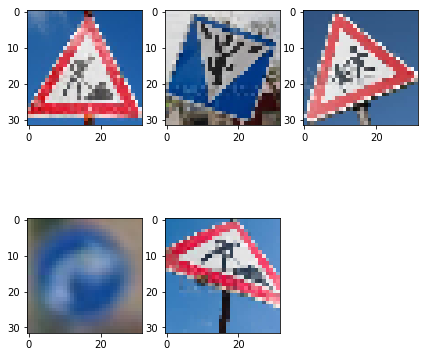

In [6]:
import matplotlib.image as mpimg
from PIL import Image
test_img_dir = "./test_images/"
test_img_names = ["img1.jpg", "img2.jpg", "img3.jpg", "img4.jpg", "img5.jpg"]

test_images = []
test_images_g = []
for i in range(5):
    img = Image.open(test_img_dir+test_img_names[i])
    resized_img = img.resize((32, 32))
    resized_arr = np.asarray(resized_img)
    test_images.append(resized_arr)
    resized_arr = rgb2gray(resized_arr).reshape((32,32,1))
    test_images_g.append(resized_arr)
    

fig = plt.figure(figsize=(7,7))
for i in range(5):
    sf = fig.add_subplot(2, 3, i+1)
    plt.imshow(test_images[i], cmap="gray")
    #sf.set_title("Image Title")

In [8]:
#restore variable state from saved model
#saver = tf.train.Saver()
res_l = [None]*5

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('model.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #saver.restore(sess, "model")
    for i in range(5):
        res_l[i] = sess.run(logits, feed_dict={x:test_images_g[i:i+1]})

tpf_p_l = [None]*5
for i in range(5):
    tpf_p = []
    tpf_d = {}
    pb = res_l[i][0]
    for p in range(len(pb)):
        tpf_p.append(pb[p])
        tpf_d[pb[p]] = p 
    tpf_p.sort(reverse=True)
    #print(tpf_p)
    tpf_p_l[i] = []
    itm_l = []
    for j in range(5):
        tpf_p_l[i].append(tpf_d[tpf_p[j]])
        itm_l.append(tpf_p[j])
    tpf_p_l[i] = list(zip(tpf_p_l[i], itm_l))
print(tpf_p_l)


FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/gpu:0"](Variable)]]
	 [[Node: Relu_4/_195 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_90_Relu_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Variable/read', defined at:
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-6431ee65968c>", line 15, in <module>
    logits = model(x)
  File "<ipython-input-4-982aa012f917>", line 9, in model
    "cnv1": tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma)),
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 224, in __init__
    expected_shape=expected_shape)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 370, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1424, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/gpu:0"](Variable)]]
	 [[Node: Relu_4/_195 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_90_Relu_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


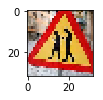

Priority road : 40.3826
Roundabout mandatory : 28.9238
Speed limit (30km/h) : 25.3591
Children crossing : 24.1629
Bicycles crossing : 16.967
-----------------------


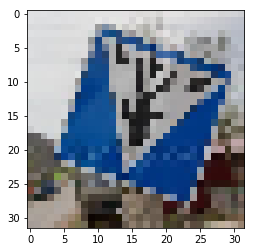

No passing for vehicles over 3.5 metric tons : 6.49147
Speed limit (80km/h) : 5.49629
Dangerous curve to the left : 3.69105
Go straight or right : 3.41452
Dangerous curve to the right : 2.61698
-----------------------


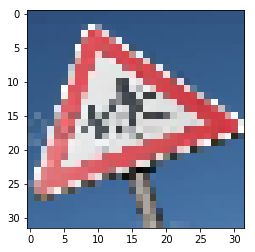

Roundabout mandatory : 19.9108
Road work : 17.7627
Keep left : 15.7227
Speed limit (20km/h) : 13.3035
Speed limit (30km/h) : 10.8914
-----------------------


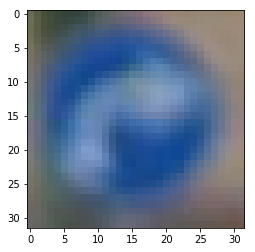

Turn right ahead : 30.6859
No passing for vehicles over 3.5 metric tons : 14.7603
No entry : 9.48856
Ahead only : 8.72646
Go straight or left : 8.66989
-----------------------


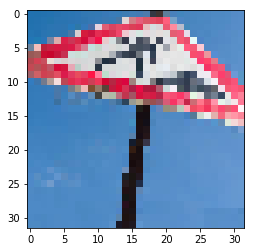

Right-of-way at the next intersection : 42.4783
Children crossing : 35.7395
General caution : 30.7156
Speed limit (60km/h) : 23.3406
Turn left ahead : 17.3014
-----------------------


In [15]:
file = open("signames.csv", 'r')
txt = file.read().split('\n')[1:]
file.close()
signs = []
for line in txt:
    signs.append(line.split(',')[-1])

#Display votes
fig = plt.figure(figsize=(7,7))
for i in range(5):
    sf = fig.add_subplot(5, 1, i+1)
    plt.imshow(test_images[i], cmap="gray")
    plt.show()
    for v in tpf_p_l[i]:
        print(signs[v[0]],":",v[1])
    print('-----------------------')